# Overhead Analysis

In [25]:
from __future__ import annotations

import json
import os
import pathlib
import tomllib

import seaborn
import polars
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [35]:
def load_tasks(filepath: pathlib.Path) -> list[dict]:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            execution_info = task_info.pop('execution')
            if execution_info is None:
                execution_info = {}
            exception_info = task_info.pop('exception')
            if exception_info is None:
                exception_info = {}
            task_info = {**task_info, **execution_info, **exception_info}
            tasks.append(task_info)

    return tasks

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.jsonl'):
        timestamp, = str(tasks_path.relative_to(directory).parent).split('/')

        with open(tasks_path.parent / 'config.toml', 'rb') as f:
            config = tomllib.load(f)
            if config['engine']['transformer']['name'] == 'proxystore':
                method = 'ProxyStore'
            else:
                method = 'Baseline'
            size = config['app']['task_data_bytes']

        for task in load_tasks(tasks_path):
            start_time = task['submit_time']
            end_time = task['received_time']       
            roundtrip = end_time - start_time
    
            run_info = {
                'method': method,
                'timestamp': timestamp,
                'roundtrip': roundtrip,
                'size': size,
            }
            runs.append(run_info)

    return polars.DataFrame(runs)

In [46]:
def load_message_pack_data(filepath: pathlib.Path) -> polars.DataFrame:
    runs = []
    with open(filepath) as f:
        for line in f.readlines():
            data = json.loads(line)
            if data['Tag'] == 'Dask Baseline':
                data['Tag'] = 'Baseline'
            elif data['Tag'] == 'w/ ProxyStore (custom)':
                data['Tag'] = 'ProxyStore'
            else:
                continue
            runs.append(data)
    data = polars.DataFrame(runs)
    return data

In [47]:
message_pack_data = load_message_pack_data('runs/message-pack.jsonl')
roundtrip_data = load_data(pathlib.Path('runs/roundtrip'))

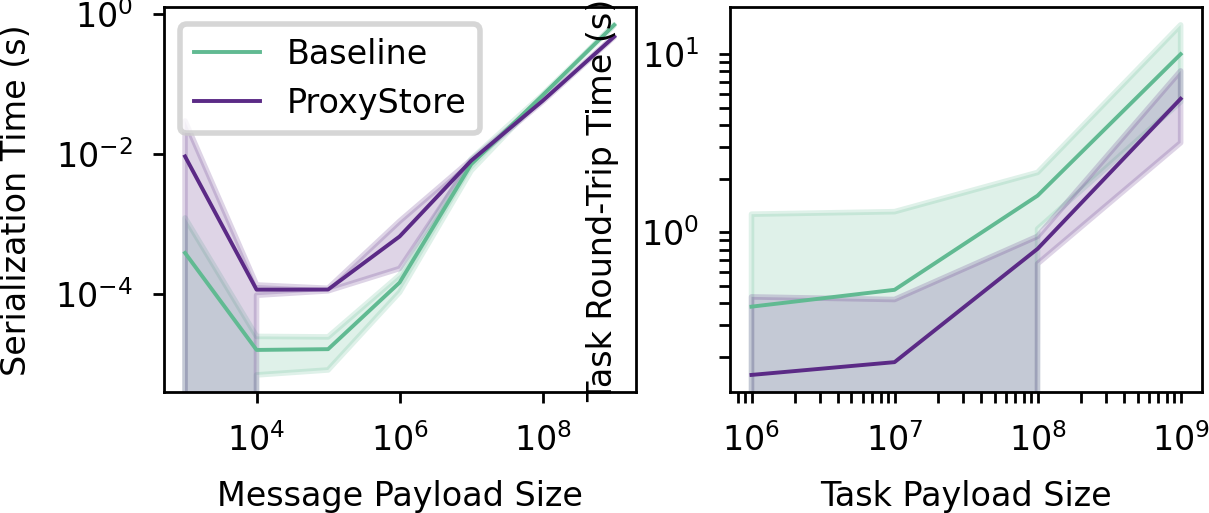

In [50]:
fig, axs = plt.subplots(1, 2)
handle = seaborn.lineplot(
    message_pack_data,
    x="Message Size",
    y="Serialize",
    hue="Tag",
    hue_order=["Baseline", "ProxyStore"],
    errorbar='sd',
    palette={'Baseline': '#61BA92', 'ProxyStore': '#5B2A86'},
    ax=axs[0],
)
handle.get_legend().set_title(None)
handle.set(
    xscale='log',
    yscale='log',
    xlabel='Message Payload Size',
    ylabel='Serialization Time (s)'
)

handle = seaborn.lineplot(
    roundtrip_data,
    x="size",
    y="roundtrip",
    hue="method",
    hue_order=["Baseline", "ProxyStore"],
    errorbar='sd',
    palette={'Baseline': '#61BA92', 'ProxyStore': '#5B2A86'},
    ax=axs[1],
)
handle.get_legend().remove()
handle.set(
    xscale='log',
    yscale='log',
    xlabel='Task Payload Size',
    ylabel='Task Round-Trip Time (s)'
)

fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/overheads.pdf', pad_inches=0.05)